In [1]:
# poröse layer und air-layer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import jv
import csv
import numpy as np
from numpy import cos, sin, pi, sqrt, abs, dot, tan, matmul

In [4]:
# MAA-Modell
# d Durchmesser, 
# dicke: dicke der Platte
# density_0, luftdichte
# viscosity. luftvisikosität

def MAA(f, d, a, t, density_0, viscosity):
    #Formulas from book aucoustic waves
    omega = 2*pi*f
    sigma = d*sqrt(omega*density_0 / (4*viscosity))
    phi = pi*d**2/4/a**2

    sigma_i = 1 + (1+0.5*sigma**2)**(-0.5) + 0.85*d/t

    sigma_tau = sqrt(1+(sigma**2)/32) + (4*sqrt(2)/32)*sigma*d/t

    Z_r = -(1j*omega*density_0*t*sigma_i/phi) + 32*viscosity*t*sigma_tau/ (phi*d**2)

    return Z_r

# f is Frequency
# d is the diameter of holes
# a is the spacing between holes
# t is thickness of panel
# density_0 is air density
# viscosity is dynamic viscosity coefficient of the air
# def MAA(f, d, a, t, density_0, viscosity):
#     ## Formulas from website
#     omega = 2*pi*f # angular frequency
#     k = d*sqrt(omega*density_0)*viscosity/2 # the ratio of the inner radius to the viscous boundary layer
#     phi = 0.785*(d/a)**2 # perforation ratio, d and a are the diameter of holes and the spacing between holes,
    
#     J_0 = jv(0, k*sqrt(-1j)) # J0 and J1 are the Bessel functions of the zero order and the first order
#     J_1 = jv(1, k*sqrt(-1j)) 

#     Z_p = (1/phi) * (1j*omega*density_0*t * (1 - 2*J_1/(k*sqrt(-1j))/J_0)**(-1) 
#                     + 1j*omega*0.425*d + sqrt(2*omega*density_0*viscosity)/4)

#     return Z_p


## Formulas from pdf 
def MAA1(f, d, a, t, density_0, viscosity,c0,L0):
    ## Formulas from website
    omega = 2*pi*f # angular frequency
    
    phi = (pi/4)*d**2/a**2 # perforation ratio, d and a are the diameter of holes and the spacing between holes,
    s = d*sqrt(density_0*omega/4/viscosity)
    S = a**2 # area of the edge effects
    D = 2*sqrt(S/pi)
    e = 1.1284*sqrt(phi)
    # D = L0
    # e = d/D
    F_e = (1- 1.4092*e + 0.33818*(e**3) + 0.06793*(e**5) - 0.02287*(e**6) + 0.03015*(e**7) - 0.01641*(e**8))**(-1)
    
    J_0 = jv(0, s*sqrt(-1j)) # J0 and J1 are the Bessel functions of the zero order and the first order
    J_1 = jv(1, s*sqrt(-1j)) 
    
    k0 = omega/c0 # wavenumber in medium
    Z0 = density_0*c0 # impendence of air medium

    # Z_p = (sqrt(2*density_0*omega*viscosity)/2/phi) + (1j*omega*density_0/phi) * (0.85*d/F_e + t*(1 - 2*J_1/(s*sqrt(-1j))/J_0)**(-1)) - 1j*Z0/tan(k0*L0)
    Z_p = (sqrt(2*density_0*omega*viscosity)/2/phi) + (1j*omega*density_0/phi) * (0.85*d/F_e + t*(1 - 2*J_1/(s*sqrt(-1j))/J_0)**(-1))


    return Z_p

In [5]:
d= 1/1000
a= 5/1000
(pi/4)*d**2/a**2

0.03141592653589793

443.76
344
1.29


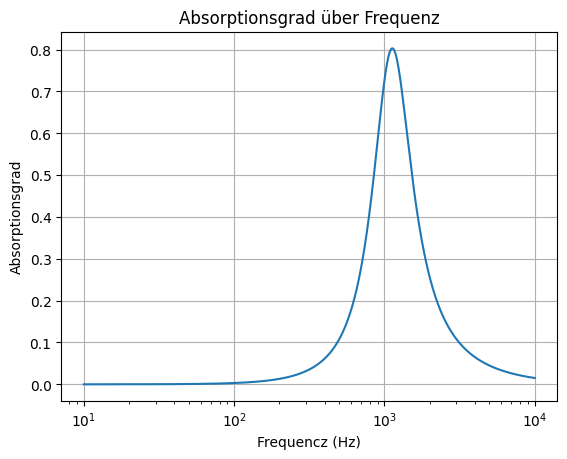

In [6]:
## Schräge Inzidenz (Oblique Incidence)
## Umgebungsparemeter 
c0 = 344 #m/s
density_0 = 1.29  # dichte von Luft-Schicht

# Platte-Parameters

d = 1/1000 # diameter
a = 5/1000 # spacing between holes

# viscosity = 1.82*10**(-5)
viscosity = 0.000186785423

# Frequenz Bereich
L1 = float(input('Lochplatte Schicht Dicke(mm):'))
t1 = L1/1000
L2 = float(input('Luft Schicht Dicke(mm):'))
L2 = L2/1000
# theta = float(input('Einfallswinkel(Grad):'))
theta = 0
theta = pi*theta/180 # theta nur rad sein können
frequency_min = 10
frequency_max = float(input('max. Frequenz:'))
frequency_range = np.arange(frequency_min, frequency_max)

alphas = np.array([]) # Array speichert Absorptionsgrad

# Impedanz
Z0 = density_0 * c0
print(Z0)
print(c0)
print(density_0)
#Z2 = luft_dichte * luft_c  # Luft-Schicht

for f in frequency_range:
    # Z1 = MAA(f, d, a, t1, density_0, viscosity)
    Z1 = MAA1(f, d, a, t1, density_0, viscosity,c0,L2)
    Z2 = Z0

    k0 = 2*pi*f / c0
    k1 = k0
    #k1 = 2*pi*f/6400 # Alu
    k2 = k0

    # T1, T2, T3 definieren

    T1 = np.array([[1, Z1],
                    [0, 1]])

    T2 = np.array([[cos(k2*L2), 1j*Z2*sin(k2*L2)],
                   [(1j/Z2)*sin(k2*L2), cos(k2*L2)]])

    # Rigid Backed
    T3 = np.array([[1, 0],  
                   [0, 1]])

    # T_total berechnen
    T_total = matmul(T1, T2)
  
    #Absorptionsgrad berechnen
    # R = (Z1 - Z0) / (Z1  + Z0)
    R = (T_total[0, 0] /T_total[1, 0]- Z0) / (T_total[0, 0]/T_total[1, 0] + Z0) # Reflexionskoeffizient
    
    alpha = 1 - (abs(R)**2)
    alphas = np.append(alphas, alpha)

# Ersetzen der Werte durch 0
alphas[(alphas < 0.000001) & (alphas > 0)] = 0

# Diagramm, Grad über Frequenz
plt.plot(frequency_range,alphas)
plt.xscale('log')
plt.xlabel('Frequencz (Hz)')
plt.ylabel('Absorptionsgrad')
plt.title('Absorptionsgrad über Frequenz')
plt.grid()
plt.show()

In [7]:
t1

0.0005